# Twitter Sentiment Analysis using RNN (Recurrent Neural Network)

RNNs are a type of ANN (artificial neural networks) designed to process sequence of data. It captures temporal dependencies in sequential data (ie. effect of current input based on the previous inputs).

RNNs work well with sequencs such as timeseries, voice and natural language.

Time series data are a collection of observations(behaviour) for a single subject(entity) at different time intervals.

Time series data can be recorded at different frequencies such as hourly, daily, weekly or monthly.

In this notebook we are looking at the capability of SimpleRNN for predicting the sentiment of a given tweet.

Lets look at the data now.

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are four classes in this dataset: Positive, Negative, Neutral and Irrelavent.

Will be using twitter_training.csv as the training set and twitter_validation.csv as the validation set.

## Install and Import Libraries

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip list | grep keras

keras                              3.4.1
scikeras                           0.13.0
tf_keras                           2.17.0


In [ ]:
!pip list | grep tensorflow

tensorflow                         2.17.0
tensorflow-datasets                4.9.6
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.0
tensorflow-probability             0.24.0


In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras as keras
import matplotlib.pyplot as plt
from collections import Counter
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
from tf_keras.regularizers import l2
from tf_keras.models import Sequential
from tf_keras.callbacks import EarlyStopping
from tf_keras.callbacks import ModelCheckpoint
from tf_keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tf_keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [5]:
import string # special operations on strings
import spacy # language models
import re

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.stem import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# to split sentence into words
from nltk.tokenize import word_tokenize

## Load and Prepare Data

In [9]:
# Load the dataset
# header=None: tells pandas that the CSV file has no headers,
# so it won't use the first row as column names.

df = pd.read_csv('/content/twitter_training.csv', header=None)

df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet']

# Display first few rows
df.head()


,ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


***As we are interested in Tweets, missing Tweet records will not add value, hence will drop them.***

In [11]:
# Dropping the ROW with Null value in any of the columns
df.dropna(inplace=True)

# Dropping the previous index and reindexing the DataFrame
df = df.reset_index(drop=True)

In [12]:
# Check for duplicates
# Look at the record count, its same 61549, for ID, or ID + Entity or all the three Columns
# Differes only when the Tweets are considered
df[df.duplicated(subset=['ID','Entity','Sentiment'])]

,ID,Entity,Sentiment,Tweet
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
73991,9200,Nvidia,Positive,Just realized that the Windows partition of my...
73992,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
73993,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
73994,9200,Nvidia,Positive,Just realized between the windows partition of...


In [13]:
# 2340 rows are duplicate
df[df.duplicated()]

,ID,Entity,Sentiment,Tweet
20,2404,Borderlands,Positive,that was the first borderlands session in a lo...
26,2405,Borderlands,Negative,The biggest disappointment of my life came a y...
51,2409,Borderlands,Neutral,Blaming Sight for Tardiness! A little bit of b...
63,2411,Borderlands,Neutral,.. [
145,2425,Borderlands,Negative,"""What a bitch!"""
...,...,...,...,...
73819,9171,Nvidia,Neutral,This benchmarking comparison between Oculus Qu...
73824,9172,Nvidia,Positive,@ NVIDIAGeForce @ nvidia
73903,9185,Nvidia,Neutral,Heard people are having issues with ordering t...
73933,9190,Nvidia,Positive,This news about the Nvidia 3000 series is ligi...


In [14]:
df[df['Tweet']=='that was the first borderlands session in a long time where i actually had a really satisfying combat experience. i got some really good kills']

,ID,Entity,Sentiment,Tweet
18,2404,Borderlands,Positive,that was the first borderlands session in a lo...
20,2404,Borderlands,Positive,that was the first borderlands session in a lo...


In [15]:
df.drop_duplicates(inplace=True)
# Dropping the previous index and reindexing the DataFrame
df = df.reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71656 entries, 0 to 71655
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         71656 non-null  int64 
 1   Entity     71656 non-null  object
 2   Sentiment  71656 non-null  object
 3   Tweet      71656 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


In [17]:
df[df['ID']==2503]

,ID,Entity,Sentiment,Tweet
569,2503,Borderlands,Neutral,. . . . . .
570,2503,Borderlands,Neutral,........
571,2503,Borderlands,Neutral,.. . . .
572,2503,Borderlands,Neutral,......


In [18]:
# While checking for duplicates, found entries which does not have any alphabets
# Lets remove them
# Step 1: Identify rows where the 'Tweet' column that contain any alphabets
no_alphabets = df['Tweet'].str.contains(r'^[^A-Za-z]*$', regex=True)
no_alphabets[572]

True

In [19]:
# Step 2: Filter out rows where 'Tweet' contains no alphabets
# ~no_alphabets: The ~ operator negates the boolean condition,
# so it selects the rows where alphabetic characters are present.
df_cleaned = df[~no_alphabets]
df_cleaned

,ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
71651,9200,Nvidia,Positive,Just realized that the Windows partition of my...
71652,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
71653,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
71654,9200,Nvidia,Positive,Just realized between the windows partition of...


In [20]:
# Dropping the previous index and reindexing the DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)

In [21]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71361 entries, 0 to 71360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         71361 non-null  int64 
 1   Entity     71361 non-null  object
 2   Sentiment  71361 non-null  object
 3   Tweet      71361 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


## Data Preprocessing

### Normalization

In [22]:
# Lets normalize the text by lower casing them.
df_cleaned['Tweet'] = df_cleaned['Tweet'].str.lower()
df_cleaned['Entity'] = df_cleaned['Entity'].str.lower()


### Leading and Trailing Space Stripping

In [23]:
# remove leading and trailing spaces
df_cleaned['Tweet'] = df_cleaned['Tweet'].str.strip()
df_cleaned['Entity'] = df_cleaned['Entity'].str.strip()


### Check Duplicates

In [24]:
# Check for duplicate tweets
df_cleaned[df_cleaned.duplicated()]

,ID,Entity,Sentiment,Tweet
41,2408,borderlands,Neutral,check out this epic streamer!.
160,2429,borderlands,Positive,bioshock and borderlands coming to the switch ...
713,2532,borderlands,Positive,completed
841,2555,borderlands,Negative,holy shit borderlands 3 is ass.
899,2566,borderlands,Neutral,sky rocket > superbadass caustic goliath. bord...
...,...,...,...,...
70970,9128,nvidia,Positive,working at nvidia should be a nice experience
70976,9129,nvidia,Positive,new nvidia reference designs certainly look......
71041,9141,nvidia,Positive,neat!! it would be nice to play
71070,9146,nvidia,Neutral,don't miss these exciting


In [25]:
df_cleaned[df_cleaned['Tweet']=='check out this epic streamer!.']

,ID,Entity,Sentiment,Tweet
40,2408,borderlands,Neutral,check out this epic streamer!.
41,2408,borderlands,Neutral,check out this epic streamer!.


In [26]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned = df_cleaned.reset_index(drop=True)

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70747 entries, 0 to 70746
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         70747 non-null  int64 
 1   Entity     70747 non-null  object
 2   Sentiment  70747 non-null  object
 3   Tweet      70747 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


### Removing STOPWORDS

In [28]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df_cleaned['Tweet'] = df_cleaned['Tweet'].apply(lambda text: cleaning_stopwords(text))
df_cleaned['Tweet'].head()

,Tweet
0,"im getting borderlands murder ,"
1,"coming borders kill all,"
2,"im getting borderlands kill all,"
3,"im coming borderlands murder all,"
4,"im getting borderlands 2 murder all,"


### Combining the features

In [29]:
# This is the feature for which sentiment to be predicted - Tweet for a given Entity
# Hence need the both to be preprocessed
df_cleaned['X'] = df_cleaned['Entity'] + " " + df_cleaned['Tweet']
df_cleaned['X'].head()

,X
0,"borderlands im getting borderlands murder ,"
1,"borderlands coming borders kill all,"
2,"borderlands im getting borderlands kill all,"
3,"borderlands im coming borderlands murder all,"
4,"borderlands im getting borderlands 2 murder all,"


### Cleaning - Punctuations, repeating characters, emails, URLs and digits

In [30]:
# remove punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

# Remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

# remove emails
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

# cleaning and removing urls
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

# cleaning numbers from Tweet
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

# split Tweets to words
def split_to_words(data):
  return word_tokenize(data)

In [31]:
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: cleaning_punctuations(x))
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: cleaning_repeating_char(x))
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: cleaning_email(x))
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: cleaning_URLs(x))
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: cleaning_numbers(x))

In [32]:
df_cleaned['X']

,X
0,borderlands im geting borderlands murder
1,borderlands coming borders kil al
2,borderlands im geting borderlands kil al
3,borderlands im coming borderlands murder al
4,borderlands im geting borderlands murder al
...,...
70742,nvidia realized windows partition mac like ye...
70743,nvidia realized mac window partition years be...
70744,nvidia realized windows partition mac years b...
70745,nvidia realized windows partition mac like ye...


### Splitting each tweets to words

In [33]:
#split words in each tweet to apply lemmatization
df_cleaned['X'] = df_cleaned['X'].apply(lambda x: split_to_words(x))

In [34]:
df_cleaned['X']

,X
0,"[borderlands, im, geting, borderlands, murder]"
1,"[borderlands, coming, borders, kil, al]"
2,"[borderlands, im, geting, borderlands, kil, al]"
3,"[borderlands, im, coming, borderlands, murder,..."
4,"[borderlands, im, geting, borderlands, murder,..."
...,...
70742,"[nvidia, realized, windows, partition, mac, li..."
70743,"[nvidia, realized, mac, window, partition, yea..."
70744,"[nvidia, realized, windows, partition, mac, ye..."
70745,"[nvidia, realized, windows, partition, mac, li..."


### Stemming

In [35]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

df_cleaned['X'] = df_cleaned['X'].apply(lambda x: stemming_on_text(x))


In [36]:
df_cleaned['X']

,X
0,"[borderlands, im, geting, borderlands, murder]"
1,"[borderlands, coming, borders, kil, al]"
2,"[borderlands, im, geting, borderlands, kil, al]"
3,"[borderlands, im, coming, borderlands, murder,..."
4,"[borderlands, im, geting, borderlands, murder,..."
...,...
70742,"[nvidia, realized, windows, partition, mac, li..."
70743,"[nvidia, realized, mac, window, partition, yea..."
70744,"[nvidia, realized, windows, partition, mac, ye..."
70745,"[nvidia, realized, windows, partition, mac, li..."


### Lemmatization

In [37]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

df_cleaned['X'] = df_cleaned['X'].apply(lambda x: lemmatizer_on_text(x))


In [38]:
df_cleaned['X']

,X
0,"[borderlands, im, geting, borderlands, murder]"
1,"[borderlands, coming, borders, kil, al]"
2,"[borderlands, im, geting, borderlands, kil, al]"
3,"[borderlands, im, coming, borderlands, murder,..."
4,"[borderlands, im, geting, borderlands, murder,..."
...,...
70742,"[nvidia, realized, windows, partition, mac, li..."
70743,"[nvidia, realized, mac, window, partition, yea..."
70744,"[nvidia, realized, windows, partition, mac, ye..."
70745,"[nvidia, realized, windows, partition, mac, li..."


### Sentiment Class Distribution

In [39]:
# Check the distribution of sentiments
df_cleaned['Sentiment'].value_counts()


,count
Sentiment,
Negative,21477
Positive,19436
Neutral,17444
Irrelevant,12390


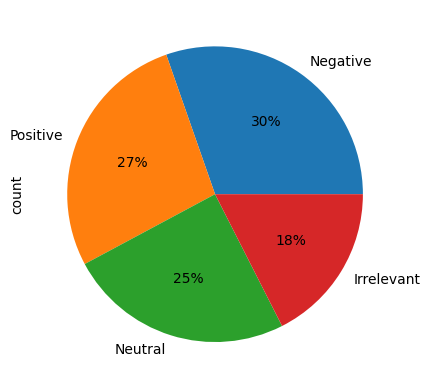

In [40]:
df_cleaned['Sentiment'].value_counts().plot(kind='pie', y='Sentiment', autopct='%1.0f%%')
plt.show()

***Learning***

The data is unbalanced between Irrelavent class the the rest of the classes. Hence we need to balance it. While trying with unbalanced data, I got better precision for Negative class while the model generalized well for Positive and Neutral classes but it suffered with Irrelevant class. So to avoid it and test the same, I am implementing class weights while fitting the model with the training dataset.

### Checking Entity

In [41]:
df_cleaned['Entity'].unique().size

32

In [42]:
df_cleaned['Entity'].value_counts()

,count
Entity,
tomclancysrainbowsix,2296
verizon,2295
maddennfl,2291
nba2k,2289
callofduty,2282
microsoft,2276
facebook,2276
leagueoflegends,2265
worldofcraft,2255


### Splitting Features and Target

In [43]:
# Split features (Tweet and Entity) and labels (Sentiment)
X = df_cleaned['X']  # Combined tweet text and entity
y = df_cleaned['Sentiment']

### Tokenizing and Padding Features

####How Many unique words as per our Data

In [44]:
import itertools
# Flatten all lists in the column
flattened_list = list(itertools.chain(*df_cleaned['X']))

# Convert the flattened list to a set to get unique words
unique_words = set(flattened_list)

len(unique_words)

38290

38290 unique words are getting TOKENIZED.

From 38290 words, the top 10,000  most frequent words from the data will be tokenized.

***Lets check if its sufficient.***

####Frequency of Unique words

In [45]:
frequency = Counter(flattened_list)

# Print the frequency of each item
print(frequency)

Counter({'’': 9252, 'game': 7939, 'like': 4786, 'facebok': 4245, 'amazon': 4183, 'verizon': 4178, 'gogle': 4141, 'microsoft': 4135, 'god': 4046, 'fifa': 3957, 'get': 3887, 'im': 3703, 'borderlands': 3671, 'nvidia': 3614, 'batlefield': 3583, 'one': 3532, 'overwatch': 3477, 'nbak': 3354, 'play': 3329, 'csgo': 3316, 'it': 3295, 'fortnite': 3215, 'realy': 3199, 'dota': 3162, 'new': 3155, 'love': 3107, 'hearthstone': 3055, 'time': 2878, 'people': 2843, 'johnson': 2819, 'se': 2752, 'cyberpunk': 2728, 'calofduty': 2725, 'shit': 2649, 'homedepot': 2493, 'leagueoflegends': 2492, 's': 2482, 'best': 2433, 'stil': 2403, 'tomclancysrainbowsix': 2296, 'madenfl': 2294, 'johnsonjohnson': 2269, 'got': 2265, 'games': 2257, 'worldofcraft': 2255, 'tomclancysghostrecon': 2253, 'asasinscred': 2240, 'apexlegends': 2238, 'even': 2212, 'calofdutyblackopscoldwar': 2200, 'great': 2195, 'grandtheftautogta': 2192, 'i': 2182, 'xboxseries': 2160, 'playstationps': 2158, 'playing': 2134, 'redeadredemptionrdr': 2134, '

In [46]:
print(frequency.items())


dict_items([('borderlands', 3671), ('im', 3703), ('geting', 1261), ('murder', 79), ('coming', 480), ('borders', 12), ('kil', 431), ('al', 812), ('spent', 187), ('hours', 576), ('making', 626), ('something', 931), ('fun', 1528), ('know', 1717), ('huge', 409), ('fan', 323), ('maya', 22), ('one', 3532), ('favorite', 610), ('characters', 223), ('decided', 219), ('make', 1639), ('walpaper', 14), ('pc', 762), ('original', 231), ('image', 69), ('versus', 18), ('creation', 7), ('made', 1032), ('enjoy', 452), ('pictwitercomlsiwfjg', 3), ('couple', 156), ('heres', 147), ('picture', 115), ('compared', 79), ('pictwitercom', 871), ('mlsiwfjg', 1), ('rhandler', 1982), ('rockhard', 4), ('la', 70), ('varlope', 4), ('rare', 34), ('powerful', 176), ('handsome', 71), ('jackpot', 7), ('xbox', 2092), ('dlvritrmtrgf', 3), ('dlvrit', 64), ('rmtrgf', 3), ('dfrit', 7), ('vita', 12), ('live', 1105), ('rock', 74), ('hard', 566), ('music', 370), ('sega', 27), ('dlvr', 66), ('e', 390), ('ihard', 1), ('like', 4786)

In [47]:
df_uniq_words = pd.DataFrame(frequency.items(),columns=['Uniq_Words','Word_Freq'])

In [48]:
df_uniq_words

,Uniq_Words,Word_Freq
0,borderlands,3671
1,im,3703
2,geting,1261
3,murder,79
4,coming,480
...,...,...
38285,maxbitcnvidiadoesnt,1
38286,elim,5
38287,unoticed,5
38288,gfn,6


In [49]:
df_uniq_words.sort_values(by='Word_Freq', ascending=False, inplace=True)

In [50]:
df_uniq_words

,Uniq_Words,Word_Freq
201,’,9252
283,game,7939
59,like,4786
2982,facebok,4245
5302,amazon,4183
...,...,...
26387,braged,1
26390,falmy,1
26396,miamis,1
26397,arables,1


In [51]:
df_uniq_words.describe()

,Word_Freq
count,38290.000000
mean,23.185923
std,158.009649
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,9252.000000


In [52]:
df_uniq_words.iloc[26850:26861,:]
#26856 should be the vocabulary length if we are to consider all words with frequecy > 1

,Uniq_Words,Word_Freq
7983,gekaybikescom,2
7986,bhmtbw,2
16778,zdnetcomarticleafter…,2
19483,hqsgdjdv,2
23088,zhkfpxvc,2
16045,youtubelanzafye,2
38020,ovspcvchv,2
32026,postmfacebokcomstoryphpstor,1
11039,wizxqupxlb,1
12794,теги,1


In [53]:
df_uniq_words.iloc[9990:9999,:]

,Uniq_Words,Word_Freq
24071,dreadhead,6
24097,frodan,6
24098,lizards,6
19200,emperor,6
24100,swidzhs,6
24101,xblyzeshs,6
19148,katpilar,6
18952,gautam,6
24289,shadowverse,6


***The vocabulary length of 10,000 will cover words with maximum frequence up till words with frequency 6.***

In [54]:
df_uniq_words.iloc[19990:19999,:]

,Uniq_Words,Word_Freq
30420,methis,3
8384,canadas,3
12835,vague,3
18680,hoist,3
10347,htpstcoxqtmpkpb,3
18686,exploring,3
13498,blasted,3
31831,opose,3
37386,apdriven,3


***The vocabulary length of 20,000 will cover words with maximum frequence up till words with frequency 3.***

In [55]:
df_uniq_words.iloc[24990:24999,:]

,Uniq_Words,Word_Freq
18755,fulpriced,2
18756,manufacturers,2
6662,frgjyhqwe,2
7477,adapter,2
19030,wtroirklu,2
21225,waves,2
21249,youtubewdaoezexqa,2
36064,ujvqkseqaf,2
11795,sfuwvzxav,2


####Tokenizing using Keras Tokenizer

In [56]:
# Tokenization and Padding
max_words = 10000  # Maximum number of words to use while tokenizing
max_len = 100      # Maximum length of each tweet while padding

# Tokenizer: convert text into sequences of integers, where each unique word
# in the text corpus is assigned a unique integer.

# num_words: this argument limits the tokenizer to use only the top max_words most frequent words
# from the dataset

# eg., if max_words=10000, only the top 10,000 most frequent words in the text corpus will be
# kept, and all other words will be ignored. This is useful to control the size of the vocabulary,
# reducing the dimensionality of the input data

# oov_token: stands for "out of vocabulary" token. This is a special token that replaces any
# word in the text that is not in the tokenizer's vocabulary (i.e., words that are not among the
# max_words most frequent words).

# Each unique word in the text is assigned an integer index by the tokenizer during the
# fitting stage (when tokenizer.fit_on_texts() is called)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Convert text to sequences
# texts_to_sequences method replaces each word in the text with its corresponding integer
# from the tokenizer's vocabulary
sequences = tokenizer.texts_to_sequences(X)



####Sequence Length and Padding

In [57]:
sequences[0]

[14, 13, 107, 14, 1609]

In [58]:
# Get the length of each string
lengths = [len(item) for item in sequences]

In [59]:
max(lengths)

164

In [60]:
min(lengths)

1

***We have Tweets with Max 164 words and minimum 1 word.***

In [61]:
# Get the count of each element in the list
count_stats = Counter(lengths)

# Display the count statistics
#print(count_stats)

print(count_stats.items())
df_text = pd.DataFrame(count_stats.items(),columns=['Len_Seq','Cnt_Sequences'])

dict_items([(5, 4041), (6, 4062), (25, 1052), (28, 837), (14, 2650), (1, 1189), (11, 3726), (12, 3192), (19, 1724), (15, 2376), (16, 2212), (18, 1736), (9, 4164), (7, 4327), (24, 1049), (26, 940), (29, 665), (20, 1463), (31, 474), (4, 3850), (13, 2937), (8, 3995), (21, 1302), (3, 3309), (30, 631), (33, 386), (23, 1076), (27, 883), (36, 155), (2, 1909), (17, 1991), (32, 424), (34, 264), (10, 3910), (37, 127), (22, 1176), (38, 98), (48, 3), (35, 199), (39, 72), (41, 32), (40, 40), (100, 7), (42, 33), (52, 2), (95, 1), (164, 1), (45, 11), (43, 16), (46, 3), (51, 2), (49, 3), (44, 7), (50, 2), (98, 1), (57, 1), (60, 1), (68, 1), (85, 1), (47, 5), (131, 1)])


In [62]:
df_text.describe()

,Len_Seq,Cnt_Sequences
count,61.000000,61.000000
mean,36.655738,1159.786885
std,30.997788,1423.823012
min,1.000000,1.000000
25%,16.000000,7.000000
50%,31.000000,474.000000
75%,46.000000,1909.000000
max,164.000000,4327.000000


In [63]:
df_text[df_text['Len_Seq']>=100]

,Len_Seq,Cnt_Sequences
42,100,7
46,164,1
60,131,1


***Sequence with lenght more than 100 are just 2 occurences only and hence limiting the padded length of the sequence to be 100.***

####Padding the Sequences

In [64]:
# Pad the sequences to ensure uniform length for all input to RNN
X_padded = pad_sequences(sequences, maxlen=max_len)


In [65]:
X_padded

array([[   0,    0,    0, ...,  107,   14, 1609],
       [   0,    0,    0, ..., 6229,  336,  182],
       [   0,    0,    0, ...,   14,  336,  182],
       ...,
       [   0,    0,    0, ...,    2,   59, 1966],
       [   0,    0,    0, ...,   89,    2, 1966],
       [   0,    0,    0, ...,    2,   59, 1966]], dtype=int32)

### Label Encoding Target

In [66]:
# Encode labels (Sentiment) into integers
label_encoder = LabelEncoder()

# This will encode classes as 0, 1, 2, 3
y_encoded = label_encoder.fit_transform(y)


In [67]:
y_encoded

array([3, 3, 3, ..., 3, 3, 3])

In [68]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

## Build SimpleRNN Model

**Embedding Layer:**
The Embedding layer in Keras is used to convert words (represented by integers) into dense vectors of fixed size. This is typically the first layer in models handling textual data. It transforms a sequence of word indices into dense vectors (embeddings) that represent the semantic properties of words in a continuous vector space.

Each word in your vocabulary is mapped to a vector of real numbers. This is especially important in NLP because raw integers (tokenized words) do not capture semantic relationships, but word embeddings do.

input_dim=vocab_size:

- This parameter specifies the size of the vocabulary, i.e., the number of unique words or tokens in your dataset.

- vocab_size is the number of unique words that the tokenizer has indexed, and this is also the number of rows in the embedding matrix.

- For example, if you set vocab_size=10000, the model will only consider the 10,000 most frequent words from your text corpus.

output_dim=embedding_dim:

- This is the dimensionality of the embedding vectors (i.e., the size of the word vectors). It specifies how many dimensions the word embeddings will have.

- Each word (or token) in the input will be represented by a vector of size embedding_dim. Common values for this are 50, 100, 200, or 300 dimensions, but you can choose based on your needs.

- For example, if embedding_dim=64, each word will be represented by a 64-dimensional vector.


input_length=max_length:

- This defines the length of the input sequences (number of tokens) that the model expects. It is the number of words in each input sentence (or padded sequence).
- max_length is usually the same value you set when you padded your sequences using pad_sequences(). It ensures that all sequences are of equal length.

In [69]:
# Define model
model = Sequential()

# Embedding layer: Converts input sequences into dense vectors of fixed size
# This parameter specifies the size of the vocabulary, i.e., the number of unique words or
# tokens in dataset
# same as num_words in tokenizer
vocab_size = 10000

# This is the dimensionality of the embedding vectors (i.e., the size of the word vectors).
# It specifies how many dimensions the word embeddings will have
embedding_dim = 64

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# SimpleRNN layer
model.add(SimpleRNN(128, kernel_regularizer='l2', return_sequences=False))
model.add(Dropout(0.2))  # Drop 20% of neurons during training



**What Does return_sequences Mean?**

- return_sequences=False: This means the RNN layer will only return the last output of the sequence (i.e., the output at the final time step).

- return_sequences=True: This means the RNN layer will return the entire sequence of outputs (i.e., an output for every time step in the input sequence).


**Why Set return_sequences=False?**

In sentiment analysis, you're typically interested in a single prediction based on the entire input sequence (a tweet or a sentence). You want the model to analyze the entire sequence and make a final decision based on the last time step, rather than outputting intermediate predictions at each time step. By setting return_sequences=False, you're telling the RNN to only output the final result, which is sufficient for tasks like classification.

**Scenario in Sentiment Analysis:**

For sentiment analysis, the final output of the RNN, after processing the whole sequence, usually contains the most relevant information for classifying the sentiment of the entire input.

Therefore:

return_sequences=False will output the last hidden state, which captures information from the entire input sequence.


**When to Use return_sequences=True:**

You would use return_sequences=True in cases where you need an output for each time step, such as:

- Sequence-to-sequence tasks (e.g., machine translation, where every word in the input needs a corresponding output word).

- Video frame analysis, where you want predictions for each frame.

- Many-to-many sequence models, like when predicting stock prices at each time step of a time series.

In [70]:
# Output layer: 4 classes, so use 4 units with softmax activation
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a checkpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 665220 (2.54 MB)
Trainable params: 665220 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Class Weights for Balancing Training Data with respect to the Sentiment Target Value

In [71]:
# Get class distribution
class_weights = dict(df_cleaned['Sentiment'].value_counts(normalize=True))

# Create inverse of distribution for class weights
total_samples = sum(df_cleaned['Sentiment'].value_counts())
class_weights = {i: total_samples/count for i, count in enumerate(df_cleaned['Sentiment'].value_counts())}


In [72]:
total_samples

70747

In [73]:
df_cleaned['Sentiment'].value_counts()

,count
Sentiment,
Negative,21477
Positive,19436
Neutral,17444
Irrelevant,12390


In [74]:
class_weights

{0: 3.294082041253434,
 1: 3.639997941963367,
 2: 4.055663838569136,
 3: 5.71000807102502}

### At 20% Dropout

In [75]:
# Fit/Train the model with class weights
history_20 = model.fit(X_train, y_train,
                       epochs=10, batch_size=32,
                       class_weight=class_weights,
                       validation_data=(X_test, y_test),
                       callbacks=[early_stopping, checkpoint])

Epoch 1/10
1769/1769 [==============================] - ETA: 0s - loss: 4.6223 - accuracy: 0.5327
Epoch 1: val_loss improved from inf to 0.96838, saving model to best_model.h5
1769/1769 [==============================] - 85s 46ms/step - loss: 4.6223 - accuracy: 0.5327 - val_loss: 0.9684 - val_accuracy: 0.7004
Epoch 2/10
   1/1769 [..............................] - ETA: 1:56 - loss: 4.4224 - accuracy: 0.7188

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1769/1769 [==============================] - ETA: 0s - loss: 2.5120 - accuracy: 0.7873
Epoch 2: val_loss improved from 0.96838 to 0.78898, saving model to best_model.h5
1769/1769 [==============================] - 82s 46ms/step - loss: 2.5120 - accuracy: 0.7873 - val_loss: 0.7890 - val_accuracy: 0.7733
Epoch 3/10
1768/1769 [============================>.] - ETA: 0s - loss: 1.6713 - accuracy: 0.8674
Epoch 3: val_loss improved from 0.78898 to 0.75862, saving model to best_model.h5
1769/1769 [==============================] - 82s 47ms/step - loss: 1.6711 - accuracy: 0.8674 - val_loss: 0.7586 - val_accuracy: 0.7852
Epoch 4/10
1768/1769 [============================>.] - ETA: 0s - loss: 1.2682 - accuracy: 0.9005
Epoch 4: val_loss did not improve from 0.75862
1769/1769 [==============================] - 83s 47ms/step - loss: 1.2687 - accuracy: 0.9005 - val_loss: 0.7622 - val_accuracy: 0.7893
Epoch 5/10
1769/1769 [==============================] - ETA: 0s - loss: 1.1253 - accuracy: 0.9115
Epo

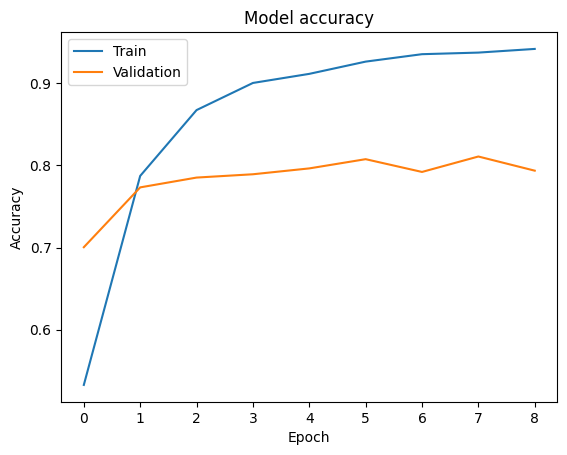

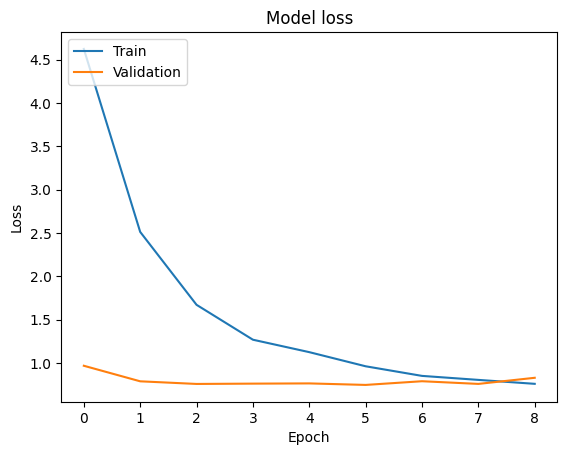

In [77]:
# Plot training & validation accuracy values
plt.plot(history_20.history['accuracy'])
plt.plot(history_20.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_20.history['loss'])
plt.plot(history_20.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### INFERENCE from Accuracy Vs Epoch Graph

The accuracy vs. epoch graph provides the following insights:

**Training Accuracy**:

- The training accuracy improves steadily over the epochs and indicates that the model is learning well on the training data

**Validation Accuracy**:

- The validation accuracy increases rapidly in the first few epochs, but reaching a plateau between epochs 4 and 9.
- Around epoch 5, the validation accuracy seems to stabilize and doesn't show much improvement.
- The gap between training and validation accuracy graph suggests that the model might be overfitting to the training data after epoch 5, as the validation performance does not significantly improve while the training accuracy continues to increase.

**Overfitting Risk**:

The increasing gap between the training and validation curves after epoch 5 indicates overfitting. The model performs better on the training data than on unseen validation data.
This could be addressed by using **early stopping** technique to halt training when validation accuracy no longer improves.


#### INFERENCE from Loss Vs Epoch Graph

The loss vs. epoch graph shows the following insights:

**Training Loss**:

- The training loss decreases steadily over the epochs.
- This suggests that the model is effectively learning from the training data and reducing errors with each epoch.

**Validation Loss**:

- The validation loss decreases sharply in the first few epochs and then plateaus, showing only minor changes after epoch 3.
- While the validation loss doesn't increase, it stabilizes, indicating that the model's generalization ability isn't improving much after the first few epochs.

**Overfitting Risk**:

- Although there isn't a large gap between training and validation loss, the fact that the training loss continues to decrease while the validation loss remains flat suggests a **minor overfitting issue**.
- The model continues to improve on the training data, but it doesn’t generalize much better on the validation data after a certain point (around epoch 3 or 4).


## Model Validation with Validation DataSet

In [87]:
# Load the dataset
# header=None: tells pandas that the CSV file has no headers,
# so it won't use the first row as column names.

test_df = pd.read_csv('/content/twitter_validation.csv', header=None)

test_df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet']

# Display first few rows
test_df.head()


,ID,Entity,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Entity     1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Tweet      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [89]:
# Check for duplicates
test_df[test_df.duplicated()]

,ID,Entity,Sentiment,Tweet


In [90]:
# Step 1: Identify rows,if any, where the 'Tweet' column that contain no alphabets
no_alphabets_ = test_df['Tweet'].str.contains(r'^[^A-Za-z]*$', regex=True)

In [91]:
no_alphabets_.any(axis=0)

False

***There are no Tweets with characters otherthan alphanumeric characters.***

In [92]:
test_df['Tweet'] = test_df['Tweet'].str.lower()
test_df['Entity'] = test_df['Entity'].str.lower()

In [93]:
test_df['Tweet'] = test_df['Tweet'].str.strip()
test_df['Entity'] = test_df['Entity'].str.strip()

In [94]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
test_df['Tweet'] = test_df['Tweet'].apply(lambda text: cleaning_stopwords(text))
test_df['Tweet'].head()

,Tweet
0,mentioned facebook struggling motivation go ru...
1,bbc news - amazon boss jeff bezos rejects clai...
2,@microsoft pay word functions poorly @samsungu...
3,"csgo matchmaking full closet hacking, truly aw..."
4,president slapping americans face really commi...


In [95]:
# This is the feature for which sentiment to be predicted - Tweet for a given Entity
# Hence need the both to be preprocessed
test_df['X'] = test_df['Entity'] + " " + test_df['Tweet']
test_df['X'].head()

,X
0,facebook mentioned facebook struggling motivat...
1,amazon bbc news - amazon boss jeff bezos rejec...
2,microsoft @microsoft pay word functions poorly...
3,"cs-go csgo matchmaking full closet hacking, tr..."
4,google president slapping americans face reall...


In [96]:
test_df['X'] = test_df['X'].apply(lambda x: cleaning_punctuations(x))
test_df['X'] = test_df['X'].apply(lambda x: cleaning_repeating_char(x))
test_df['X'] = test_df['X'].apply(lambda x: cleaning_email(x))
test_df['X'] = test_df['X'].apply(lambda x: cleaning_URLs(x))
test_df['X'] = test_df['X'].apply(lambda x: cleaning_numbers(x))

In [97]:
#split words in each tweet to apply lemmatization
test_df['X'] = test_df['X'].apply(lambda x: split_to_words(x))

In [98]:
test_df['X'] = test_df['X'].apply(lambda x: stemming_on_text(x))


In [99]:
test_df['X'] = test_df['X'].apply(lambda x: lemmatizer_on_text(x))

In [100]:
# Split features (Tweet and Entity) and labels (Sentiment)
X_test = test_df['X']  # Combine tweet text and entity
y_test = test_df['Sentiment']

In [101]:
# Tokenize and pad sequences for the test data
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Convert sentiment labels to numerical format
y_test = label_encoder.transform(y_test)


In [102]:
from tf_keras.models import load_model

# Load the model with the best validation loss
best_model = load_model('best_model.h5')


In [103]:
# Make predictions on the test data
predictions = best_model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert the numerical labels back to sentiment labels
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)


32/32 [==============================] - 1s 10ms/step


In [104]:
predicted_labels

array([0, 2, 1, 1, 2, 1, 3, 0, 3, 1, 3, 3, 1, 2, 1, 3, 3, 1, 3, 1, 3, 2,
       3, 1, 2, 2, 1, 2, 0, 1, 3, 3, 2, 3, 1, 2, 2, 0, 3, 2, 3, 2, 2, 2,
       3, 2, 0, 1, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 0, 1, 2,
       1, 2, 2, 1, 2, 1, 3, 0, 3, 0, 3, 0, 2, 2, 1, 3, 3, 2, 3, 2, 1, 0,
       3, 2, 2, 2, 3, 2, 0, 1, 1, 1, 2, 1, 2, 1, 3, 3, 2, 2, 2, 3, 1, 2,
       0, 3, 1, 0, 1, 2, 2, 3, 3, 0, 1, 1, 3, 0, 2, 1, 3, 2, 1, 2, 0, 3,
       0, 3, 3, 0, 0, 2, 0, 0, 0, 3, 2, 2, 0, 0, 3, 2, 2, 2, 1, 1, 2, 3,
       2, 0, 2, 1, 3, 3, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 3, 3, 3, 2, 3, 3,
       0, 3, 2, 3, 3, 2, 1, 1, 2, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2, 1, 1, 1,
       1, 3, 2, 2, 3, 3, 2, 3, 1, 3, 3, 0, 2, 0, 1, 1, 0, 3, 1, 3, 3, 1,
       0, 1, 2, 3, 1, 0, 0, 3, 2, 1, 3, 0, 2, 0, 2, 1, 2, 3, 2, 1, 0, 0,
       3, 3, 0, 0, 2, 1, 1, 1, 3, 1, 3, 3, 2, 3, 3, 1, 2, 1, 2, 1, 2, 2,
       1, 3, 3, 0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2, 3, 1, 1, 1, 3, 1, 2, 3,
       1, 2, 1, 3, 1, 3, 1, 3, 2, 2, 3, 1, 2, 1, 0,

In [105]:
predicted_sentiments

array(['Irrelevant', 'Neutral', 'Negative', 'Negative', 'Neutral',
       'Negative', 'Positive', 'Irrelevant', 'Positive', 'Negative',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Positive', 'Negative', 'Positive', 'Negative',
       'Positive', 'Neutral', 'Positive', 'Negative', 'Neutral',
       'Neutral', 'Negative', 'Neutral', 'Irrelevant', 'Negative',
       'Positive', 'Positive', 'Neutral', 'Positive', 'Negative',
       'Neutral', 'Neutral', 'Irrelevant', 'Positive', 'Neutral',
       'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral',
       'Irrelevant', 'Negative', 'Positive', 'Neutral', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Positive', 'Irrelevant', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral',
       'Negative', 'Positive', 'Irrelevant', 'Positive', 'I

In [106]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report (precision, recall, f1-score)
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))


Test Accuracy: 85.10%
              precision    recall  f1-score   support

  Irrelevant       0.85      0.80      0.82       172
    Negative       0.88      0.92      0.90       266
     Neutral       0.84      0.81      0.83       285
    Positive       0.83      0.86      0.84       277

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



***Lets look at the Classification Report for the SimpleRNN's sentiment prediction on validation dataset:***

**Overall Accuracy of the Model is 85.10%**

**Class-wise Performance**

1- **Irrelevant**:

Precision: 0.85 – 85% of the tweets predicted as "Irrelevant" were actually irrelevant.

Recall: 0.80 – The model correctly identified 80% of all actual irrelevant tweets.

F1-Score: 0.82 – This balanced score suggests acceptable performance for this class.

2- **Negative**:

Precision: 0.88 – 88% of the tweets predicted as "Negative" were indeed negative.

Recall: 0.92 – 92% of all negative tweets were correctly identified.

F1-Score: 0.90 – The model performs particularly well on negative sentiments.

3- **Neutral**:

Precision: 0.84 – 84% of the neutral predictions were accurate.

Recall: 0.81 – The model successfully identified 81% of all neutral tweets.

F1-Score: 0.83 – An acceptable score for neutral predictions.

4- **Positive**:

Precision: 0.83 – 83% of the positive predictions were accurate.

Recall: 0.86 – The model captured 86% of the true positive tweets.

F1-Score: 0.84 – An acceptable score for Positive predictions.

**Macro Average and Weighted Average**:

- Macro Avg:

  Precision: 0.85
  Recall: 0.85
  F1-Score: 0.85

  These are simple averages across all classes, showing the overall performance is balanced across all sentiments.

- Weighted Avg:

  Precision: 0.85
  Recall: 0.85
  F1-Score: 0.85

  This accounts for the support (number of samples) in each class, indicating that the model performs consistently well across the dataset, even when some classes have more examples than others.

***Insights***:

The model performs good with all classes of Sentiments as we have used Class Weights for the Dataset to balance them across the Sentiments.

Without balancing the classes the prediction suffered for the least sampled Sentiment, which was tested before finalizing the notebook.

In [107]:
# Add predictions to the test DataFrame
test_df['predicted_sentiment'] = predicted_sentiments

# Save the predictions to a CSV file
test_df.to_csv('tweet_test_predictions.csv', index=False)
#test_df

# SUMMARY

The Simple RNN assignment helped in understanding how to use different layers to build an RNN model, how to configure the parameters and how to evaluate model performance.

It very well covered the NLP aspect for processing the Tweets to be able to passed to the model.

Coming at the model training, we have seen how we can save a model before it gets overfit and then use the saved model to predict on the unseen data and evaluate the model performance.